OpenAI Generation

In [ ]:
# Install the newer OpenAI SDK
!pip install --upgrade openai

from openai import OpenAI
import pandas as pd
import random
import re

In [ ]:
client = OpenAI(api_key="KEY_GOES_HERE")

def query_chatGPT(prompt):
    """Send a prompt to OpenAI GPT-4o."""
    response = client.chat.completions.create(
        model="gpt-4o-mini",       # you can change to gpt-4o if you want
        messages=[{"role": "user", "content": prompt}],
        max_tokens=400,
        temperature=1
    )
    return response.choices[0].message.content

In [ ]:
# download public domain poems
poems_df = pd.read_csv(
    'https://github.com/maria-antoniak/poetry-eval/'
    'raw/refs/heads/main/data/poetry-evaluation_public-domain-poems.csv'
)

# keep sonnets & ghazals
poems_df = poems_df[poems_df['form'].isin(['sonnet', 'ghazal'])]

# random 25 sonnets + 2 ghazals
sample_df = poems_df[poems_df['form'] == 'sonnet'].sample(25)
sample_df = pd.concat([sample_df, poems_df[poems_df['form'] == 'ghazal']])

# load brown poems
import gdown
url = "https://drive.google.com/file/d/1SqTw3A99hPDbTUxZ-OoJD4wGdl0ZF3Oz/view?usp=sharing"
output = "brown_poems.csv"
gdown.download(url=url, output=output, fuzzy=True)

brown_df = pd.read_csv("brown_poems.csv")

# reduce sample_df columns
sample_df = sample_df[['author', 'poem_title', 'poem_text', 'form']]

# combine datasets
combined_df = pd.concat([sample_df, brown_df])

Downloading...
From: https://drive.google.com/uc?id=1SqTw3A99hPDbTUxZ-OoJD4wGdl0ZF3Oz
To: /content/brown_poems.csv
100%|██████████| 3.18k/3.18k [00:00<00:00, 8.18MB/s]


In [ ]:
prompt_template_start = '''
Read the following poem and classify its form as: [sonnet, ghazal, duplex].
You must choose exactly ONE.

Return the answer in this format:

1. Poetic Form: ...
2. Elaborated Rationale: ...
3. One-Word Summary: ...
4. Confidence Score: ...

Poem Text:
'''

prompt_template_end = '''

Pick ONE of these forms: [sonnet, ghazal, duplex].
'''

In [ ]:
def extract_response_fields(response):
    """Parse the classification output."""
    lines = response.strip().split('\n')

    result = {
        'poetic_form': None,
        'rationale': None,
        'summary': None,
        'confidence': None
    }

    for line in lines:
        if line.startswith('1. Poetic Form:'):
            result['poetic_form'] = line.split(':', 1)[1].strip()
        elif line.startswith('2. Elaborated Rationale:'):
            result['rationale'] = line.split(':', 1)[1].strip()
        elif line.startswith('3. One-Word Summary:'):
            result['summary'] = line.split(':', 1)[1].strip()
        elif line.startswith('4. Confidence Score:'):
            result['confidence'] = line.split(':', 1)[1].strip()

    return result

In [ ]:
for index, row in combined_df.iterrows():
    prompt = prompt_template_start + row['poem_text'] + prompt_template_end
    response = query_chatGPT(prompt)
    fields = extract_response_fields(response)

    combined_df.at[index, 'poetic_form'] = fields['poetic_form']
    combined_df.at[index, 'rationale'] = fields['rationale']
    combined_df.at[index, 'summary'] = fields['summary']
    combined_df.at[index, 'confidence'] = fields['confidence']

combined_df.to_csv("combined_df.csv", index=False)

In [ ]:
subjects = [
    "abuse",
    "activities",
    "arts & sciences",
    "christianity",
    "chronic illness",
    "crime & punishment",
    "cycles",
    "desire & passion",
    "doubt & contemplation",
    "family & ancestors",
    "gender & sexuality",
    "greek & roman mythology",
    "history & politics",
    "home life",
    "hope",
    "humor & satire",
    "indoor activities",
    "life choices",
    "lgbtq+",
    "living",
    "love",
    "love death avoidance",
    "memory & nostalgia",
    "men & women",
    "mythology & folklore",
    "nature",
    "power",
    "poetry & poets",
    "race & ethnicity",
    "relationships",
    "romantic love",
    "sexual violence",
    "sorrow & grieving",
    "social commentaries",
    "subjugation",
    "the mind",
    "trees and flowers",
    "truth",
    "twilight",
    "urban environment",
    "war & conflict",
    "weather",
    "youth"
]


def generate_general_prompt(subject, form="Duplex"):
    return f"Write a poem about the subject of {subject} in the form: {form}."


def generate_figurative_prompt(subject, form="Duplex"):
    return f"Write a poem about the subject of {subject} in the form: {form}. Do not use the words {subject} or {form}."


def generate_specific_prompt(subject, form="Duplex"):
    return f"Write a poem about the subject of {subject} in the form: {form}. Make it about something specific."


new_poems_df = pd.DataFrame(columns=['subject', 'form', 'prompt_type', 'poem_text'])

for subject in subjects:
    genPrompt = generate_general_prompt(subject)
    figPrompt = generate_figurative_prompt(subject)
    specPrompt = generate_specific_prompt(subject)

    genResponse = query_chatGPT(genPrompt)
    figResponse = query_chatGPT(figPrompt)
    specResponse = query_chatGPT(specPrompt)

    new_poems_df.loc[len(new_poems_df)] = [subject, "Duplex", "general", genResponse]
    new_poems_df.loc[len(new_poems_df)] = [subject, "Duplex", "figurative", figResponse]
    new_poems_df.loc[len(new_poems_df)] = [subject, "Duplex", "specific", specResponse]

new_poems_df.to_csv("new_poems_df.csv", index=False)

print("All tasks complete.")

All tasks complete.


In [ ]:
BROWN_RULES = """
Write a poem in the Duplex form as defined by Jericho Brown.
You MUST follow ALL of these rules:

1. The poem has exactly 14 lines.
2. Each line must contain between 9 and 11 syllables.
3. The poem should blend qualities of ghazal, sonnet, and blues traditions.
4. Line 1 is repeated as Line 14.
5. Line 2 must reinterpret Line 1 in an unexpected way.
6. Line 2 is repeated as Line 3.
7. Line 4 must reinterpret Line 3 in an unexpected way.
8. This pattern of echo / reinterpretation continues until Line 13.
9. Line 13 becomes the first line of the couplet that leads to the final line (Line 14).
10. The poem’s theme should be rooted in emotional tension, reflection, or personal revelation.
"""

In [ ]:
def generate_general_prompt(subject, form="Duplex"):
    return (
        f"{BROWN_RULES}\n\n"
        f"Write a poem about the subject of {subject} in the form: {form}.\n"
        f"The poem MUST follow all Duplex rules above."
    )


def generate_figurative_prompt(subject, form="Duplex"):
    return (
        f"{BROWN_RULES}\n\n"
        f"Write a poem about the subject of {subject} in the form: {form}.\n"
        f"Do NOT use the words '{subject}' or '{form}' anywhere in the poem.\n"
        f"The poem MUST follow all Duplex rules above."
    )


def generate_specific_prompt(subject, form="Duplex"):
    return (
        f"{BROWN_RULES}\n\n"
        f"Write a poem about the subject of {subject} in the form: {form}.\n"
        f"Make the poem about a very specific moment, object, place, or memory.\n"
        f"The poem MUST follow all Duplex rules above."
    )

In [ ]:
new_brown_poems_df = pd.DataFrame(
    columns=['subject', 'form', 'prompt_type', 'poem_text']
)

In [ ]:
for subject in subjects:

    # build 3 prompt types
    genPrompt = generate_general_prompt(subject)
    figPrompt = generate_figurative_prompt(subject)
    specPrompt = generate_specific_prompt(subject)

    # call your model function (this is unchanged)
    genResponse = query_chatGPT(genPrompt)
    figResponse = query_chatGPT(figPrompt)
    specResponse = query_chatGPT(specPrompt)

    # store in your preferred format
    new_brown_poems_df.loc[len(new_brown_poems_df)] = [
        subject, "Duplex", "general", genResponse
    ]
    new_brown_poems_df.loc[len(new_brown_poems_df)] = [
        subject, "Duplex", "figurative", figResponse
    ]
    new_brown_poems_df.loc[len(new_brown_poems_df)] = [
        subject, "Duplex", "specific", specResponse
    ]

GPT 4o Generation

In [ ]:
# imports
import pandas as pd
import gdown


In [ ]:
# download human-authored poems from LK's gdrive
url = "https://drive.google.com/file/d/19RXOfv3MgMxF_f-fxwOnwhOKlbYSsERO/view?usp=drive_link"

output = "human_poems_sample.csv"

gdown.download(url=url, output=output, fuzzy=True)


Downloading...
From: https://drive.google.com/uc?id=19RXOfv3MgMxF_f-fxwOnwhOKlbYSsERO
To: /content/human_poems_sample.csv
100%|██████████| 84.2k/84.2k [00:00<00:00, 63.6MB/s]


'human_poems_sample.csv'

In [ ]:
poems_df = pd.read_csv("human_poems_sample.csv")

poems_df

,poem_title,poem_text,author,form
0,[Weaned from life and flown away],Weaned from life and flown away\nIn the mornin...,Emily Brontë,sonnet
1,Of Love: A Sonnet,"How love came in I do not know,\nWhether by th...",Robert Herrick,sonnet
2,"Sonnet XLIV [For Thee the Sun Doth Daily Rise,...","For thee the sun doth daily rise, and set \nBe...",George Santayana,sonnet
3,That you were once unkind befriends me now (So...,"That you were once unkind befriends me now,\nA...",William Shakespeare,sonnet
4,Sonnet 18: Shall I compare thee to a summer’s ...,Shall I compare thee to a summer’s day?\nThou ...,William Shakespeare,sonnet
...,...,...,...,...
89,Blind Boone’s Apparitions,C\n\nmy motto for life\n\n ...,Tyehimba Jess,blues poem
90,Spring 1931,Northern black\nboy traveling\nwith empty bell...,Sam Cornish,blues poem
91,Riverbank Blues,"A man git his feet set in a sticky mudbank,\nA...",Sterling A. Brown,blues poem
92,"Go Down, Death","(A Funeral Sermon)\n\nWeep not, weep not,\nShe...",James Weldon Johnson,blues poem


In [ ]:
# set up the prompt template
# this is borrowed from the "Sonnet or Not" paper

prompt_template_start = '''
Read the following poem and then respond with the form of the poem based on the following verse forms: [’sonnet’, ’ghazal’, ’duplex’, 'blues poem'].
All of the poems have been tagged by experts as one of these forms. You must pick one of these options.
Please also provide an elaborated rationale for why you think the poem is in this form, a one-word summary rationale, and a score ranking your confidence in your answer from 0 to 1. Please report the single poetic form, elaborated rationale, and one-word rationale in the following format.
1. Poetic Form: Sonnet
2. Elaborated Rationale: This poem is a sonnet because...
3. One-Word Summary: Meter
4. Confidence Score : 0.73

1. Poetic Form: Ghazal
2. Elaborated Rationale: This poem is a ballad because...
3. One-Word Summary: Rhyme
4. Confidence Score : 0.91

Poem Text (in full):

'''

prompt_template_end = '''

Pick ONE of these possible verse forms: [’sonnet’, ’ghazal’, ’duplex’, 'blues poem'].
'''

In [ ]:
# import random module
import random

# generate a random number betweeen 0 and the lenght of poems_df
num = random.randint(0, len(poems_df) - 1)

# piece together the prompt
test_prompt = prompt_template_start + poems_df.iloc[num]['poem_text'] + prompt_template_end

# just take a look before we use it
print(test_prompt)


Read the following poem and then respond with the form of the poem based on the following verse forms: [’sonnet’, ’ghazal’, ’duplex’, 'blues poem'].
All of the poems have been tagged by experts as one of these forms. You must pick one of these options.
Please also provide an elaborated rationale for why you think the poem is in this form, a one-word summary rationale, and a score ranking your confidence in your answer from 0 to 1. Please report the single poetic form, elaborated rationale, and one-word rationale in the following format.
1. Poetic Form: Sonnet
2. Elaborated Rationale: This poem is a sonnet because...
3. One-Word Summary: Meter
4. Confidence Score : 0.73

1. Poetic Form: Ghazal
2. Elaborated Rationale: This poem is a ballad because...
3. One-Word Summary: Rhyme
4. Confidence Score : 0.91

Poem Text (in full):

Oh, oh, you will be sorry for that word!
Give back my book and take my kiss instead.
Was it my enemy or my friend I heard,
“What a big book for such a little head

In [ ]:
# Install the newer OpenAI SDK
!pip install --upgrade openai

from openai import OpenAI
import pandas as pd
import random
import re

client = OpenAI(api_key="KEY_GOES_HERE")

def query_chatGPT(prompt):
    """Send a prompt to OpenAI GPT-4o."""
    response = client.chat.completions.create(
        model="gpt-4o-mini",       # you can change to gpt-4o if you want
        messages=[{"role": "user", "content": prompt}],
        max_tokens=400,
        temperature=1
    )
    return response.choices[0].message.content

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.6 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 2.8.1
    Uninstalling openai-2.8.1:
      Successfully uninstalled openai-2.8.1


In [ ]:
# test model

response = client.chat.completions.create( # Use the chat completions endpoint
  model="gpt-4o-mini",
  messages=[
        {"role": "user", "content": "Say this is a test"}, # Use messages parameter for chat models
    ],
  max_tokens=7,
  temperature=0
)

print(response.choices[0].message.content)

This is a test. How can


In [ ]:
# define the actual query function

def query_chatGPT (prompt):
  response = client.chat.completions.create( # Use the chat completions endpoint
    model="gpt-4o-mini",
    messages=[
      {"role": "user", "content": prompt}, # Use messages parameter for chat models
    ],
    max_tokens=400, # up the number of tokens for a longer answer, remove additional responses below
    temperature=1
  )

  response_text = response.choices[0].message.content

  return(response_text)

In [ ]:
# try once before we do it all

# test model

response = client.chat.completions.create( # Use the chat completions endpoint
  model="gpt-4o-mini",
  messages=[
        {"role": "user", "content": test_prompt}, # Use messages parameter for chat models
    ],
  max_tokens=400,
  temperature=1
)

print(response.choices[0].message.content)

1. Poetic Form: Sonnet  
2. Elaborated Rationale: This poem is a sonnet because it consists of 14 lines structured in a specific rhyme scheme (ABABCDCDEFEFGG) that conforms to the traditional English sonnet format. Additionally, it explores themes of love, conflict, and resolution, which are common in sonnets. The poem contains a turn or volta in the final couplet, highlighting a shift in emotion and perspective, reinforcing its classification as a sonnet.  
3. One-Word Summary: Structure  
4. Confidence Score: 0.85


In [ ]:
def extract_response_fields(response):
    """
    Extract structured fields from a response with the format:
    1. Poetic Form: ...
    2. Elaborated Rationale: ...
    3. One-Word Summary: ...
    4. Confidence Score: ...

    Args:
        response (str): The full model output string

    Returns:
        dict: Dictionary with keys 'poetic_form', 'rationale', 'summary', 'confidence'
    """
    lines = response.strip().split('\n')

    result = {
        'poetic_form': None,
        'rationale': None,
        'summary': None,
        'confidence': None
    }

    for line in lines:
        if line.startswith('1. Poetic Form:'):
            result['poetic_form'] = line.split(':', 1)[1].strip()
        elif line.startswith('2. Elaborated Rationale:'):
            result['rationale'] = line.split(':', 1)[1].strip()
        elif line.startswith('3. One-Word Summary:'):
            result['summary'] = line.split(':', 1)[1].strip()
        elif line.startswith('4. Confidence Score:'):
            result['confidence'] = line.split(':', 1)[1].strip()

    return result


# Usage:
fields = extract_response_fields(response.choices[0].message.content)
print(fields)
# Output: {'poetic_form': '...', 'rationale': '...', 'summary': '...', 'confidence': '...'}

# Access individual values:
response1 = fields['poetic_form']
response2 = fields['rationale']
response3 = fields['summary']
response4 = fields['confidence']

{'poetic_form': 'Sonnet', 'rationale': 'This poem is a sonnet because it consists of 14 lines structured in a specific rhyme scheme (ABABCDCDEFEFGG) that conforms to the traditional English sonnet format. Additionally, it explores themes of love, conflict, and resolution, which are common in sonnets. The poem contains a turn or volta in the final couplet, highlighting a shift in emotion and perspective, reinforcing its classification as a sonnet.', 'summary': 'Structure', 'confidence': '0.85'}


In [ ]:
# iterate through every row in poems_df
for index, row in poems_df.iterrows():
  # construct prompt from that row's ['poem_text']
  prompt = prompt_template_start + row['poem_text'] + prompt_template_end

  # get response from prompt
  response = query_chatGPT(prompt)

  # extract response fields using extract_response_fields
  fields = extract_response_fields(response)

  # add fields to poems_df
  poems_df.at[index, 'poetic_form'] = fields['poetic_form']
  poems_df.at[index, 'rationale'] = fields['rationale']
  poems_df.at[index, 'summary'] = fields['summary']
  poems_df.at[index, 'confidence'] = fields['confidence']

poems_df


poems_df.to_csv('gpt4o_poems_and_tags_df.csv', index=False)

In [ ]:
# replace any NaN in poems_df["poetic_form"] with "Unclassified"
poems_df['poetic_form'] = poems_df['poetic_form'].fillna('unclassified')
# turn all values in poems_df["poetic_form"] to lowercase
poems_df['poetic_form'] = poems_df['poetic_form'].str.lower()
# view value counts of poems_df['poetic_form']
poems_df['poetic_form'].value_counts()

,count
poetic_form,
sonnet,47
ghazal,27
blues poem,11
duplex,9


In [ ]:


import re

def strip_non_letters_and_conditionally_remove_s(input_string):
    # match any non-letter character
    pattern = re.compile(r'[^a-zA-Z\s]')
    cleaned_string = pattern.sub('', input_string)

    # Remove 's' at the end of the phrase unless the phrase is "ekphrasis" or "ars poetic"
    if cleaned_string.lower().endswith('s') and not cleaned_string.lower().endswith('ekphrasis') and not cleaned_string.lower().endswith('ars poetica'):
        cleaned_string = cleaned_string[:-1]

    return cleaned_string

In [ ]:
# define a function to evaluate whether the model got the form "correct" or not

def evaluate(row):
    # Convert columns to string type, handling potential NaN values
    form_str = str(row['form']).strip().lower()
    poetic_form_str = str(row['poetic_form']).strip().lower()

    if form_str == strip_non_letters_and_conditionally_remove_s(poetic_form_str):
        return 1
    else:
        return 0

In [ ]:
# apply it to determine true correctness
poems_df['true_correctness'] = poems_df.apply(evaluate, axis = 'columns')

poems_df

,poem_title,poem_text,author,form,poetic_form,rationale,summary,confidence,true_correctness
0,[Weaned from life and flown away],Weaned from life and flown away\nIn the mornin...,Emily Brontë,sonnet,blues poem,This poem reflects the themes commonly found i...,Emotion,0.80,0
1,Of Love: A Sonnet,"How love came in I do not know,\nWhether by th...",Robert Herrick,sonnet,ghazal,This poem resembles a ghazal because it explor...,Theme,0.85,0
2,"Sonnet XLIV [For Thee the Sun Doth Daily Rise,...","For thee the sun doth daily rise, and set \nBe...",George Santayana,sonnet,sonnet,This poem is a sonnet because it consists of 1...,Structure,0.95,1
3,That you were once unkind befriends me now (So...,"That you were once unkind befriends me now,\nA...",William Shakespeare,sonnet,sonnet,This poem is a sonnet because it follows the s...,Structure,0.95,1
4,Sonnet 18: Shall I compare thee to a summer’s ...,Shall I compare thee to a summer’s day?\nThou ...,William Shakespeare,sonnet,sonnet,This poem is a sonnet because it follows the t...,Structure,0.95,1
...,...,...,...,...,...,...,...,...,...
89,Blind Boone’s Apparitions,C\n\nmy motto for life\n\n ...,Tyehimba Jess,blues poem,ghazal,This poem is a ghazal because it consists of a...,Couplets,0.85,0
90,Spring 1931,Northern black\nboy traveling\nwith empty bell...,Sam Cornish,blues poem,blues poem,This poem embodies the essence of a blues poem...,Rhythm,0.95,1
91,Riverbank Blues,"A man git his feet set in a sticky mudbank,\nA...",Sterling A. Brown,blues poem,blues poem,This poem is a blues poem because it incorpora...,Struggle,0.88,1
92,"Go Down, Death","(A Funeral Sermon)\n\nWeep not, weep not,\nShe...",James Weldon Johnson,blues poem,blues poem,This poem is a blues poem because it incorpora...,Emotion,0.88,1


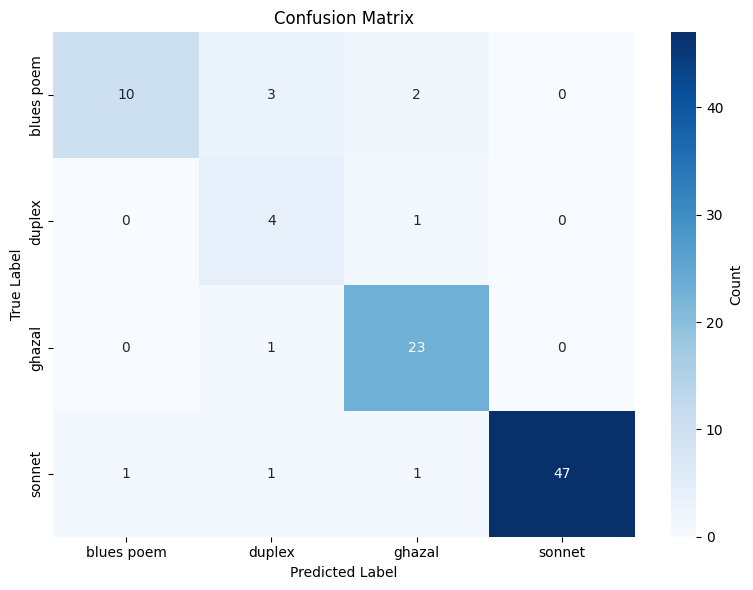

In [ ]:
# plot confusion matrix for poems_df["form"] and poems_df["poetic_form"]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

df = pd.DataFrame({'y_true': poems_df['form'], 'y_pred': poems_df['poetic_form']})

# Calculate the confusion matrix
cm = confusion_matrix(df['y_true'], df['y_pred'])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(df['y_pred']),
            yticklabels=np.unique(df['y_true']),
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Using the same data
y_true = poems_df['form']
y_pred = poems_df['poetic_form']

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision and recall with different averaging methods
# 'macro' - unweighted mean (treats all classes equally)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)

print(f"\nMacro-averaged:")
print(f"Precision: {precision_macro:.4f}")
print(f"Recall: {recall_macro:.4f}")

# 'weighted' - weighted by support (accounts for class imbalance)
precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"\nWeighted-averaged:")
print(f"Precision: {precision_weighted:.4f}")
print(f"Recall: {recall_weighted:.4f}")

# Get detailed per-class metrics
print("\n" + "="*60)
print("Detailed Classification Report:")
print("="*60)
print(classification_report(y_true, y_pred, zero_division=0))

Accuracy: 0.8936

Macro-averaged:
Precision: 0.8013
Recall: 0.8413

Weighted-averaged:
Precision: 0.9181
Recall: 0.8936

Detailed Classification Report:
              precision    recall  f1-score   support

  blues poem       0.91      0.67      0.77        15
      duplex       0.44      0.80      0.57         5
      ghazal       0.85      0.96      0.90        24
      sonnet       1.00      0.94      0.97        50

    accuracy                           0.89        94
   macro avg       0.80      0.84      0.80        94
weighted avg       0.92      0.89      0.90        94

